In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns 
import matplotlib.pyplot as plt
import EpiClockNBL.src.util as pc_util
nbl_consts = pc_util.consts
import EpiClockNBL.Select_fCpGs.util as local_util
import copy

In [2]:
# Output directories

proj_dir = os.path.join(nbl_consts['official_indir'], 'TARGET')

figure_outdir = 'figures'
output_dir = 'outputs'
outfile_dir = os.path.join(output_dir, 'outfiles')
outdir = proj_dir

os.makedirs(figure_outdir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(outfile_dir, exist_ok=True)
os.makedirs(outdir, exist_ok=True)

In [3]:
path_dict = {}
path_dict['tumor'] = os.path.join(proj_dir, 'cohort1.methyl.tsv')
# path_dict['normal'] = os.path.join(nbl_consts['official_indir'], 'Normals', f'beta_values-{normals_TCGA_name}.tsv')

data = local_util.getDataDict(path_dict, filter_tum_samps=False, assert_same_sites=False)
data['tumor']['beta_values'] = data['tumor']['beta_values'].dropna(axis=1, how='all')
data['tumor']['pureSamples'] = data['tumor']['pureSamples'][np.isin(data['tumor']['pureSamples'], data['tumor']['beta_values'].columns)]

In [4]:
outfile_path = os.path.join(proj_dir, 'beta_values_unbiased_sites.txt')

criteria = copy.deepcopy(local_util.CLOCK_CRITERIA)

# NO NORMAL SAMPLE
if 'normal' not in data['cohorts']:
    del criteria['normal']

unbiased_sites = local_util.gen_CpG_set(data, criteria=criteria, neutral_DNA_CpG_list=None)
data['tumor']['beta_values_SELECTION'].loc[unbiased_sites].to_csv(outfile_path, sep='\t')

Selecting CpGs with:
	213 TCGA samples


## Figure

In [5]:
## Configure graph
sf = nbl_consts['sf']
figsize = np.array([9, 7])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

In [6]:
mean_only_criteria = copy.deepcopy(local_util.CLOCK_CRITERIA)
del mean_only_criteria['normal']
del mean_only_criteria['tumor']['beta_nan_fracs']
mean_only_criteria

mean_only_sites = local_util.gen_CpG_set(data, criteria=mean_only_criteria, neutral_DNA_CpG_list=None)

Selecting CpGs with:
	213 TCGA samples


In [9]:
data['tumor']['beta_values_SELECTION'].shape

(485577, 213)

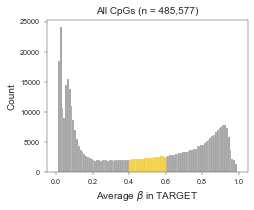

In [7]:
## Inter-tumor mean
# Plot inter-tumor mean beta for each unbiased site

# Create plot
fig, ax = plt.subplots(1, 1, figsize=figsize * sf)

binwidth=0.01
# bins = np.concatenate([
#     getBinEdges(data['tumor']['beta_means'].loc[data['allCpGs']].min(), data['tumor']['beta_means'].loc[unbiased_sites].min(), binwidth, hardStop=True),
#     getBinEdges(data['tumor']['beta_means'].loc[unbiased_sites].max(), data['tumor']['beta_means'].loc[data['allCpGs']].max(), binwidth, hardStop=False)
# ])

bins = np.concatenate([
    local_util.getBinEdges(data['tumor']['beta_means'].min(), data['tumor']['beta_means'].loc[mean_only_sites].min(), binwidth, hardStop=True),
    local_util.getBinEdges(data['tumor']['beta_means'].loc[mean_only_sites].max(), data['tumor']['beta_means'].max(), binwidth, hardStop=False)
])
sns.histplot(ax=ax,      # Biased sites
             # x=data['tumor']['beta_means'].loc[list(set(data['allCpGs']).difference(set(unbiased_sites)))],
             x=data['tumor']['beta_means'].loc[list(set(data['allCpGs']).difference(set(mean_only_sites)))],
             color=nbl_consts['palette_jco'][2], alpha=nbl_consts['opacity'],
             # binwidth=binwidth
             bins = bins
            )
sns.histplot(ax=ax,      # Unbiased sites
             # x=data['tumor']['beta_means'].loc[unbiased_sites],
             x=data['tumor']['beta_means'].loc[mean_only_sites],
             color=nbl_consts['palette_jco'][1], alpha=nbl_consts['opacity'], binwidth=binwidth
            )

# Customize figure
ax.set_xlabel(r'Average $\beta$ in TARGET', fontsize=nbl_consts['labelfontsize'] * sf)
ax.set_ylabel(ax.get_ylabel(), fontsize=nbl_consts['labelfontsize'] * sf)
ax.set_title(f'All CpGs (n = {data["tumor"]["beta_means"].shape[0]:,})', fontsize=nbl_consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=nbl_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Label fluctuating sites
# ax.text(0.5, 0.5, 'Unbiased CpGs',
#         ha="left", va="bottom", fontfamily='sans-serif', color='black',
#         fontsize=nbl_consts['labelfontsize'] * 0.8 * sf)

# Save figure
fig.savefig(os.path.join(figure_outdir, 'pick_unbiased_sites.svg'), format='svg', pad_inches=0.1)

# Purity QC

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


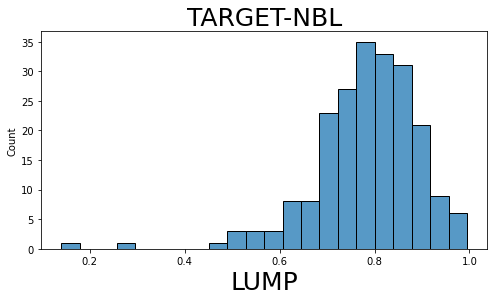

In [5]:
# Examine LUMP values - will not filter for now
LUMP_values = pc_util.getLUMP_values(data['tumor']['beta_values'])
sf = 1

fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(LUMP_values)

ax.set_xlabel('LUMP', fontsize=nbl_consts['labelfontsize']*sf)
ax.set_title('TARGET-NBL', fontsize=nbl_consts['labelfontsize']*sf)

LUMP_values.to_csv(os.path.join(proj_dir, 'LUMP_purity.txt'), sep='\t')